In [ ]:
pip install torch torchvision scikit-learn matplotlib tqdm nflows joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=488e40769d005c908df7bff6f6d632f279d1e38e078151f30f1cb88145529870
  Stored in directory: /root/.cache/pip/wheels/fd/27/c3/8952205ea17b63dc1eaa24031e63111c6a3661cb22cc1e2a3c
Successfully built nflows


In [ ]:
#Hyperparameters and imports

latentDim = 32
flowSteps = 6
flowHiddenDim = 128
gmmComponents = 30
gmmRegCovar = 1e-3
aeEpochs = 15
flowEpochs = 30
batchSize = 256
lr = 1e-3
flowLr = 1e-4
weightDecay = 1e-5
betaKl = 1.0
numSamples = 64
seed = 42
useAmp = True
numWorkers = 2
pinMemory = True
evalClassifierEpochs = 10

import gc, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torchvision import datasets, transforms
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms import CompositeTransform, MaskedAffineAutoregressiveTransform
from nflows.transforms import BatchNorm as NFlowsBatchNorm
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    useAmp = False
    pinMemory = False
    batchSize = min(batchSize, 64)

def setSeed(s=42):
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def clearMemory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

setSeed(seed)

In [ ]:
#Load MNIST

setSeed(seed)
mnistTrainData = torchvision.datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=ToTensor())
mnistTestData = torchvision.datasets.MNIST(
    root="mnist_data", train=False, download=True, transform=ToTensor())
trainLoader = torch.utils.data.DataLoader(mnistTrainData, batch_size=batchSize)
testLoader  = torch.utils.data.DataLoader(mnistTestData,  batch_size=batchSize)
print(f"Train: {len(mnistTrainData)}, Test: {len(mnistTestData)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]

Train: 60000, Test: 10000


In [ ]:
#Define the different models

class ConvEncoderVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.convLayers = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.GroupNorm(8, 32), nn.SiLU(), nn.Dropout2d(0.1),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(8, 64), nn.SiLU(), nn.Dropout2d(0.1),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.GroupNorm(8, 128), nn.SiLU(),
        )
        with torch.no_grad():
            dummy = self.convLayers(torch.zeros(1, 1, 28, 28))
            self.flatSize = dummy.numel()
            self.convShape = dummy.shape[1:]
        self.fcShared = nn.Sequential(nn.Linear(self.flatSize, 256), nn.SiLU(), nn.Dropout(0.1))
        self.fcMu = nn.Linear(256, latentDim)
        self.fcLogvar = nn.Linear(256, latentDim)

    def forward(self, x):
        h = self.convLayers(x).view(x.size(0), -1)
        h = self.fcShared(h)
        return self.fcMu(h), self.fcLogvar(h)


class ConvDecoder(nn.Module):
    def __init__(self, convShape, flatSize):
        super().__init__()
        self.convShape = convShape
        self.fc = nn.Sequential(
            nn.Linear(latentDim, 256), nn.SiLU(),
            nn.Linear(256, flatSize), nn.SiLU()
        )
        self.deconvLayers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.GroupNorm(8, 64), nn.SiLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.GroupNorm(8, 32), nn.SiLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
        )

    def forward(self, z):
        h = self.fc(z).view(z.size(0), *self.convShape)
        h = self.deconvLayers(h)
        if h.size(-1) != 28:
            h = F.interpolate(h, size=(28, 28), mode='bilinear', align_corners=False)
        return h


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ConvEncoderVAE()
        self.decoder = ConvDecoder(self.encoder.convShape, self.encoder.flatSize)

    def reparameterize(self, mu, logvar):
        return mu + torch.exp(0.5 * logvar) * torch.randn_like(mu)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), z, mu, logvar

    def encode(self, x):
        mu, _ = self.encoder(x)
        return mu

    def decode(self, z):
        return self.decoder(z)


class NFlowsWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        xforms = []
        for i in range(flowSteps):
            xforms.append(MaskedAffineAutoregressiveTransform(
                features=latentDim, hidden_features=flowHiddenDim, num_blocks=2))
            if i < flowSteps - 1:
                xforms.append(NFlowsBatchNorm(features=latentDim))
        self._transform = CompositeTransform(xforms)
        self.flowModel = Flow(self._transform, StandardNormal([latentDim]))

    def forward(self, x):
        return self._transform(x)

    def inverse(self, u):
        return self._transform.inverse(u)

    def logProb(self, x, baseLogProbFn=None):
        if baseLogProbFn is None:
            return self.flowModel.log_prob(x)
        u, logDet = self.forward(x)
        return baseLogProbFn(u) + logDet


class MixtureBase:
    def __init__(self, nComponents):
        self.nComponents = nComponents
        self.model = None
        self.isFitted = False
        self.zMean = None
        self.zStd = None

    def fit(self, z):
        self.model = GaussianMixture(
            n_components=self.nComponents, covariance_type='full',
            reg_covar=float(gmmRegCovar), max_iter=200, random_state=seed, verbose=0)
        self.model.fit(z)
        self.isFitted = True

    def _getParamsTorch(self, dev):
        covs = np.array([np.diag(c) if c.ndim == 2 else c for c in self.model.covariances_])
        wT = torch.tensor(self.model.weights_, dtype=torch.float32, device=dev)
        mT = torch.tensor(self.model.means_, dtype=torch.float32, device=dev)
        cT = torch.clamp(torch.tensor(covs, dtype=torch.float32, device=dev), min=1e-6, max=1e6)
        return wT, mT, 1.0 / (cT + 1e-6), torch.sum(torch.log(cT + 1e-6), dim=1)

    @torch.no_grad()
    def logProb(self, u):
        wT, mT, invV, logDet = self._getParamsTorch(str(u.device))
        diff = u.unsqueeze(1) - mT.unsqueeze(0)
        mahal = torch.sum((diff ** 2) * invV.unsqueeze(0), dim=2)
        d = u.shape[1]
        logNorm = -0.5 * d * float(np.log(2 * np.pi)) - 0.5 * logDet.unsqueeze(0)
        logW = torch.log(wT.unsqueeze(0) + 1e-12)
        return torch.logsumexp(logW + logNorm - 0.5 * mahal, dim=1)

    def sample(self, n, dev="cpu"):
        s, _ = self.model.sample(n)
        return torch.tensor(s.astype(np.float32), device=dev)

    def sampleFromComponent(self, k, n, dev="cpu"):
        s = np.random.multivariate_normal(
            self.model.means_[k], self.model.covariances_[k], size=n).astype(np.float32)
        return torch.tensor(s, device=dev)


class FlowModel(nn.Module):
    def __init__(self, vae, flow, mixBase):
        super().__init__()
        self.vae = vae
        self.flow = flow
        self.mixBase = mixBase

    def _normTensors(self, dev):
        return (torch.tensor(self.mixBase.zMean, dtype=torch.float32, device=dev),
                torch.tensor(self.mixBase.zStd,  dtype=torch.float32, device=dev))

    @torch.no_grad()
    def sample(self, n, dev=None):
        dev = dev or next(self.parameters()).device
        self.eval()
        u = self.mixBase.sample(n, dev)
        zNorm, _ = self.flow.inverse(u)
        zM, zS = self._normTensors(dev)
        z = zNorm * zS + zM
        return torch.sigmoid(self.vae.decode(z))

    @torch.no_grad()
    def sampleFromComponent(self, k, n, dev=None):
        dev = dev or next(self.parameters()).device
        self.eval()
        u = self.mixBase.sampleFromComponent(k, n, dev)
        zNorm, _ = self.flow.inverse(u)
        zM, zS = self._normTensors(dev)
        z = zNorm * zS + zM
        return torch.sigmoid(self.vae.decode(z))


def standardNormalLogProb(u):
    d = u.shape[1]
    return -0.5 * torch.sum(u * u, dim=1) - 0.5 * d * math.log(2 * math.pi)

In [ ]:
#Train VAE

vae = VAE().to(device)
optimizer = AdamW(vae.parameters(), lr=lr, weight_decay=weightDecay)
scheduler = OneCycleLR(optimizer, max_lr=lr * 5, epochs=aeEpochs,
                       steps_per_epoch=max(1, len(trainLoader)))
scaler = GradScaler(enabled=useAmp and device == "cuda")

vaeLossHistory = []

for epoch in range(aeEpochs):
    vae.train()
    totalLoss, n = 0.0, 0
    pbar = tqdm(trainLoader, desc=f"VAE {epoch+1}/{aeEpochs}", leave=False)
    for batch in pbar:
        x = batch[0].to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=useAmp and device == "cuda"):
            logits, zSample, mu, logvar = vae(x)
            reconLoss = F.binary_cross_entropy_with_logits(logits, x, reduction='sum')
            kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = reconLoss + betaKl * kl
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        totalLoss += loss.item()
        n += x.size(0)
        pbar.set_postfix(loss=f"{totalLoss/n:.4f}")
    epochLoss = totalLoss / n
    vaeLossHistory.append(epochLoss)
    print(f"  Epoch {epoch+1}: loss/sample = {epochLoss:.4f}")

/tmp/ipython-input-2825244343.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=useAmp and device == "cuda")


VAE 1/15:   0%|          | 0/235 [00:00<?, ?it/s]

/tmp/ipython-input-2825244343.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=useAmp and device == "cuda"):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  Epoch 1: loss/sample = 216.4157


VAE 2/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 2: loss/sample = 118.0637


VAE 3/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 3: loss/sample = 112.8328


VAE 4/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 4: loss/sample = 110.1263


VAE 5/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 5: loss/sample = 107.7976


VAE 6/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 6: loss/sample = 105.2437


VAE 7/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 7: loss/sample = 103.8196


VAE 8/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 8: loss/sample = 101.9910


VAE 9/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 9: loss/sample = 100.6116


VAE 10/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 10: loss/sample = 99.4121


VAE 11/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 11: loss/sample = 98.3079


VAE 12/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 12: loss/sample = 97.4184


VAE 13/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 13: loss/sample = 96.5655


VAE 14/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 14: loss/sample = 96.0151


VAE 15/15:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 15: loss/sample = 95.6859


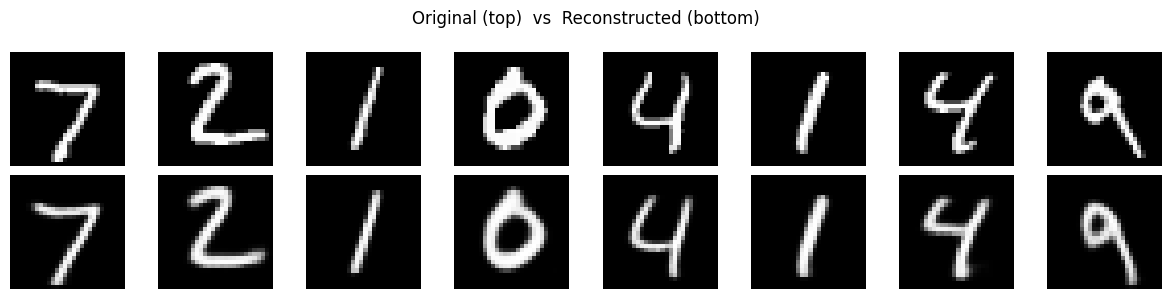

In [ ]:
#Test VAE Reconstruction

vae.eval()
xSample = next(iter(testLoader))[0][:8].to(device)
with torch.no_grad():
    reconLogits, _, _, _ = vae(xSample)
    xRecon = torch.sigmoid(reconLogits)

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
fig.suptitle("Original (top)  vs  Reconstructed (bottom)")
for i in range(8):
    axes[0, i].imshow(xSample[i].cpu().squeeze(), cmap='gray'); axes[0, i].axis('off')
    axes[1, i].imshow(xRecon[i].cpu().squeeze(),  cmap='gray'); axes[1, i].axis('off')
plt.tight_layout(); plt.show()
clearMemory()

In [ ]:
#Train Flow Model

@torch.no_grad()
def encodeDataset(model, loader):
    model.eval()
    parts = []
    for batch in tqdm(loader, desc="Encoding", leave=False):
        x = batch[0].to(device, non_blocking=True)
        with autocast(enabled=useAmp and device == "cuda"):
            z = model.encode(x)
        parts.append(z.float().cpu().numpy())
    return np.concatenate(parts)

latents = encodeDataset(vae, trainLoader)
zMean = latents.mean(axis=0).astype(np.float32)
zStd  = (latents.std(axis=0) + 1e-8).astype(np.float32)
latentsNorm = (latents - zMean) /zStd

flowModel = NFlowsWrapper().to(device)
ds = TensorDataset(torch.tensor(latentsNorm, dtype=torch.float32))
flowLoader = DataLoader(ds, batch_size=batchSize, shuffle=True, pin_memory=pinMemory)

optFlow = AdamW(flowModel.parameters(), lr=flowLr, weight_decay=weightDecay)
schFlow = OneCycleLR(optFlow, max_lr=max(flowLr*3, 1e-5), epochs=flowEpochs,
                     steps_per_epoch=max(1, len(flowLoader)))
scalerFlow = GradScaler(enabled=useAmp and device == "cuda")

flowNllHistory = []

for epoch in range(flowEpochs):
    flowModel.train()
    totalLoss, nBatches = 0.0, 0
    pbar = tqdm(flowLoader, desc=f"Flow {epoch+1}/{flowEpochs}", leave=False)
    for (zBatch,) in pbar:
        zBatch = zBatch.to(device, non_blocking=True)
        optFlow.zero_grad(set_to_none=True)
        with autocast(enabled=useAmp and device == "cuda"):
            lp = flowModel.logProb(zBatch, standardNormalLogProb)
            loss = -lp.mean()
        if torch.isnan(loss) or torch.isinf(loss):
            continue
        scalerFlow.scale(loss).backward()
        scalerFlow.unscale_(optFlow)
        torch.nn.utils.clip_grad_norm_(flowModel.parameters(), 0.5)
        scalerFlow.step(optFlow)
        scalerFlow.update()
        schFlow.step()
        totalLoss += loss.item()
        nBatches += 1
        pbar.set_postfix(nll=f"{totalLoss/nBatches:.3f}")
    epochNll = totalLoss / max(nBatches, 1)
    flowNllHistory.append(epochNll)
    print(f"  Epoch {epoch+1}: NLL = {epochNll:.4f}")

Encoding:   0%|          | 0/235 [00:00<?, ?it/s]

/tmp/ipython-input-951928206.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=useAmp and device == "cuda"):
/tmp/ipython-input-951928206.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scalerFlow = GradScaler(enabled=useAmp and device == "cuda")


Flow 1/30:   0%|          | 0/235 [00:00<?, ?it/s]

/tmp/ipython-input-951928206.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=useAmp and device == "cuda"):


  Epoch 1: NLL = 51.8633


Flow 2/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 2: NLL = 46.2862


Flow 3/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 3: NLL = 40.8057


Flow 4/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 4: NLL = 38.4144


Flow 5/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 5: NLL = 36.9527


Flow 6/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 6: NLL = 35.8051


Flow 7/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 7: NLL = 34.8590


Flow 8/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 8: NLL = 34.0241


Flow 9/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 9: NLL = 33.3140


Flow 10/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 10: NLL = 32.6866


Flow 11/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 11: NLL = 32.1317


Flow 12/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 12: NLL = 31.6721


Flow 13/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 13: NLL = 31.2574


Flow 14/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 14: NLL = 30.8643


Flow 15/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 15: NLL = 30.5327


Flow 16/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 16: NLL = 30.2298


Flow 17/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 17: NLL = 29.9323


Flow 18/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 18: NLL = 29.7044


Flow 19/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 19: NLL = 29.4792


Flow 20/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 20: NLL = 29.2894


Flow 21/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 21: NLL = 29.1215


Flow 22/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 22: NLL = 28.9552


Flow 23/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 23: NLL = 28.8307


Flow 24/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 24: NLL = 28.7137


Flow 25/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 25: NLL = 28.6463


Flow 26/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 26: NLL = 28.5685


Flow 27/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 27: NLL = 28.5355


Flow 28/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 28: NLL = 28.4933


Flow 29/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 29: NLL = 28.4808


Flow 30/30:   0%|          | 0/235 [00:00<?, ?it/s]

  Epoch 30: NLL = 28.4467


In [ ]:
#Fit GMMs

flowModel.eval()
with torch.no_grad():
    uAll, _ = flowModel.forward(torch.tensor(latentsNorm, dtype=torch.float32).to(device))
    uAllNp = uAll.cpu().numpy()

nComp = gmmComponents
mixBase = MixtureBase(nComp)
mixBase.fit(uAllNp)
mixBase.zMean = zMean
mixBase.zStd  = zStd

weights = mixBase.model.weights_
active = np.sum(weights > 1e-3)
print(f"GMM fitted: {nComp} components, {active} active (weight > 1e-3)")

GMM fitted: 30 components, 30 active (weight > 1e-3)


In [ ]:
#Test Flow Model

@torch.no_grad()
def evaluateFlow(flow, mix, rawLatents):
    flow.eval()
    lNorm = (rawLatents - mix.zMean) / (mix.zStd + 1e-8)
    ds2 = TensorDataset(torch.tensor(lNorm, dtype=torch.float32))
    ldr = DataLoader(ds2, batch_size=batchSize)
    totalLp, n = 0.0, 0
    for (zb,) in ldr:
        zb = zb.to(device)
        lp = flow.logProb(zb, mix.logProb)
        totalLp += lp.sum().item()
        n += zb.shape[0]
    avg = totalLp / n
    bpd = -avg / (rawLatents.shape[1] * np.log(2))
    return avg, bpd, n

testLatents = encodeDataset(vae, testLoader)
avgLp, bpd, nEval = evaluateFlow(flowModel, mixBase, testLatents)
print(f"Test set — avg log-prob: {avgLp:.4f}, bits/dim: {bpd:.4f}, samples: {nEval}")

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-951928206.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=useAmp and device == "cuda"):


Test set — avg log-prob: -27.2646, bits/dim: 1.2292, samples: 10000


In [ ]:
#Train Classifier that will be used to evaluate our created digits

model = FlowModel(vae, flowModel, mixBase).to(device)

class SmallClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256), nn.ReLU(),
            nn.Linear(256, 10))
    def forward(self, x):
        return self.net(x)

classifier = SmallClassifier().to(device)
optCls = torch.optim.Adam(classifier.parameters(), lr=1e-3)
critCls = nn.CrossEntropyLoss()
for ep in range(evalClassifierEpochs):
    classifier.train()
    for x, y in tqdm(trainLoader, desc=f"Classifier {ep+1}/{evalClassifierEpochs}", leave=False):
        x, y = x.to(device), y.to(device)
        loss = critCls(classifier(x), y)
        optCls.zero_grad(); loss.backward(); optCls.step()

classifier.eval()

correct = 0
total = 0
with torch.no_grad():
    for x, y in testLoader:
        x, y = x.to(device), y.to(device)
        logits = classifier(x)
        preds = torch.argmax(logits, dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

test_acc = correct/total
print(f"Final Test Accuracy: {test_acc:.4f}\n")

Classifier 1/10:   0%|          | 0/235 [00:00<?, ?it/s]

Classifier 2/10:   0%|          | 0/235 [00:00<?, ?it/s]

Classifier 3/10:   0%|          | 0/235 [00:00<?, ?it/s]

Classifier 4/10:   0%|          | 0/235 [00:00<?, ?it/s]

Classifier 5/10:   0%|          | 0/235 [00:00<?, ?it/s]

Classifier 6/10:   0%|          | 0/235 [00:00<?, ?it/s]

Classifier 7/10:   0%|          | 0/235 [00:00<?, ?it/s]

Classifier 8/10:   0%|          | 0/235 [00:00<?, ?it/s]

Classifier 9/10:   0%|          | 0/235 [00:00<?, ?it/s]

Classifier 10/10:   0%|          | 0/235 [00:00<?, ?it/s]

Final Test Accuracy: 0.9861



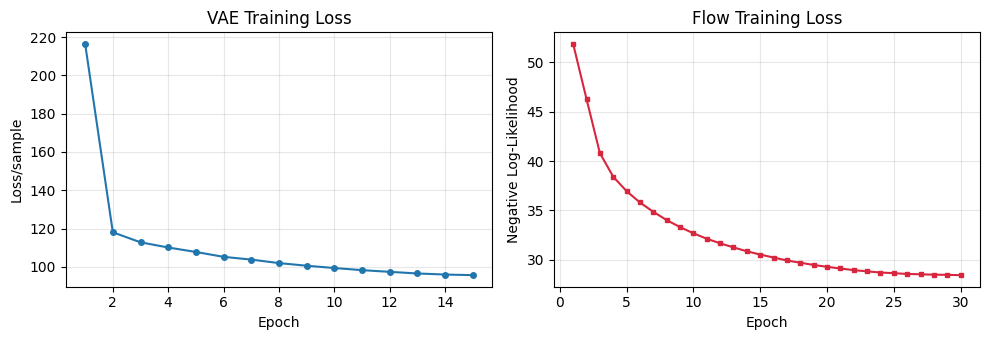

In [ ]:
#Create loss graphs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))

ax1.plot(range(1, aeEpochs + 1), vaeLossHistory, 'o-', color='#2176AE', markersize=4, linewidth=1.5)
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss/sample")
ax1.set_title("VAE Training Loss"); ax1.grid(True, alpha=0.3)

ax2.plot(range(1, flowEpochs + 1), flowNllHistory, 's-', color='#D7263D', markersize=3, linewidth=1.5)
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Negative Log-Likelihood")
ax2.set_title("Flow Training Loss"); ax2.grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

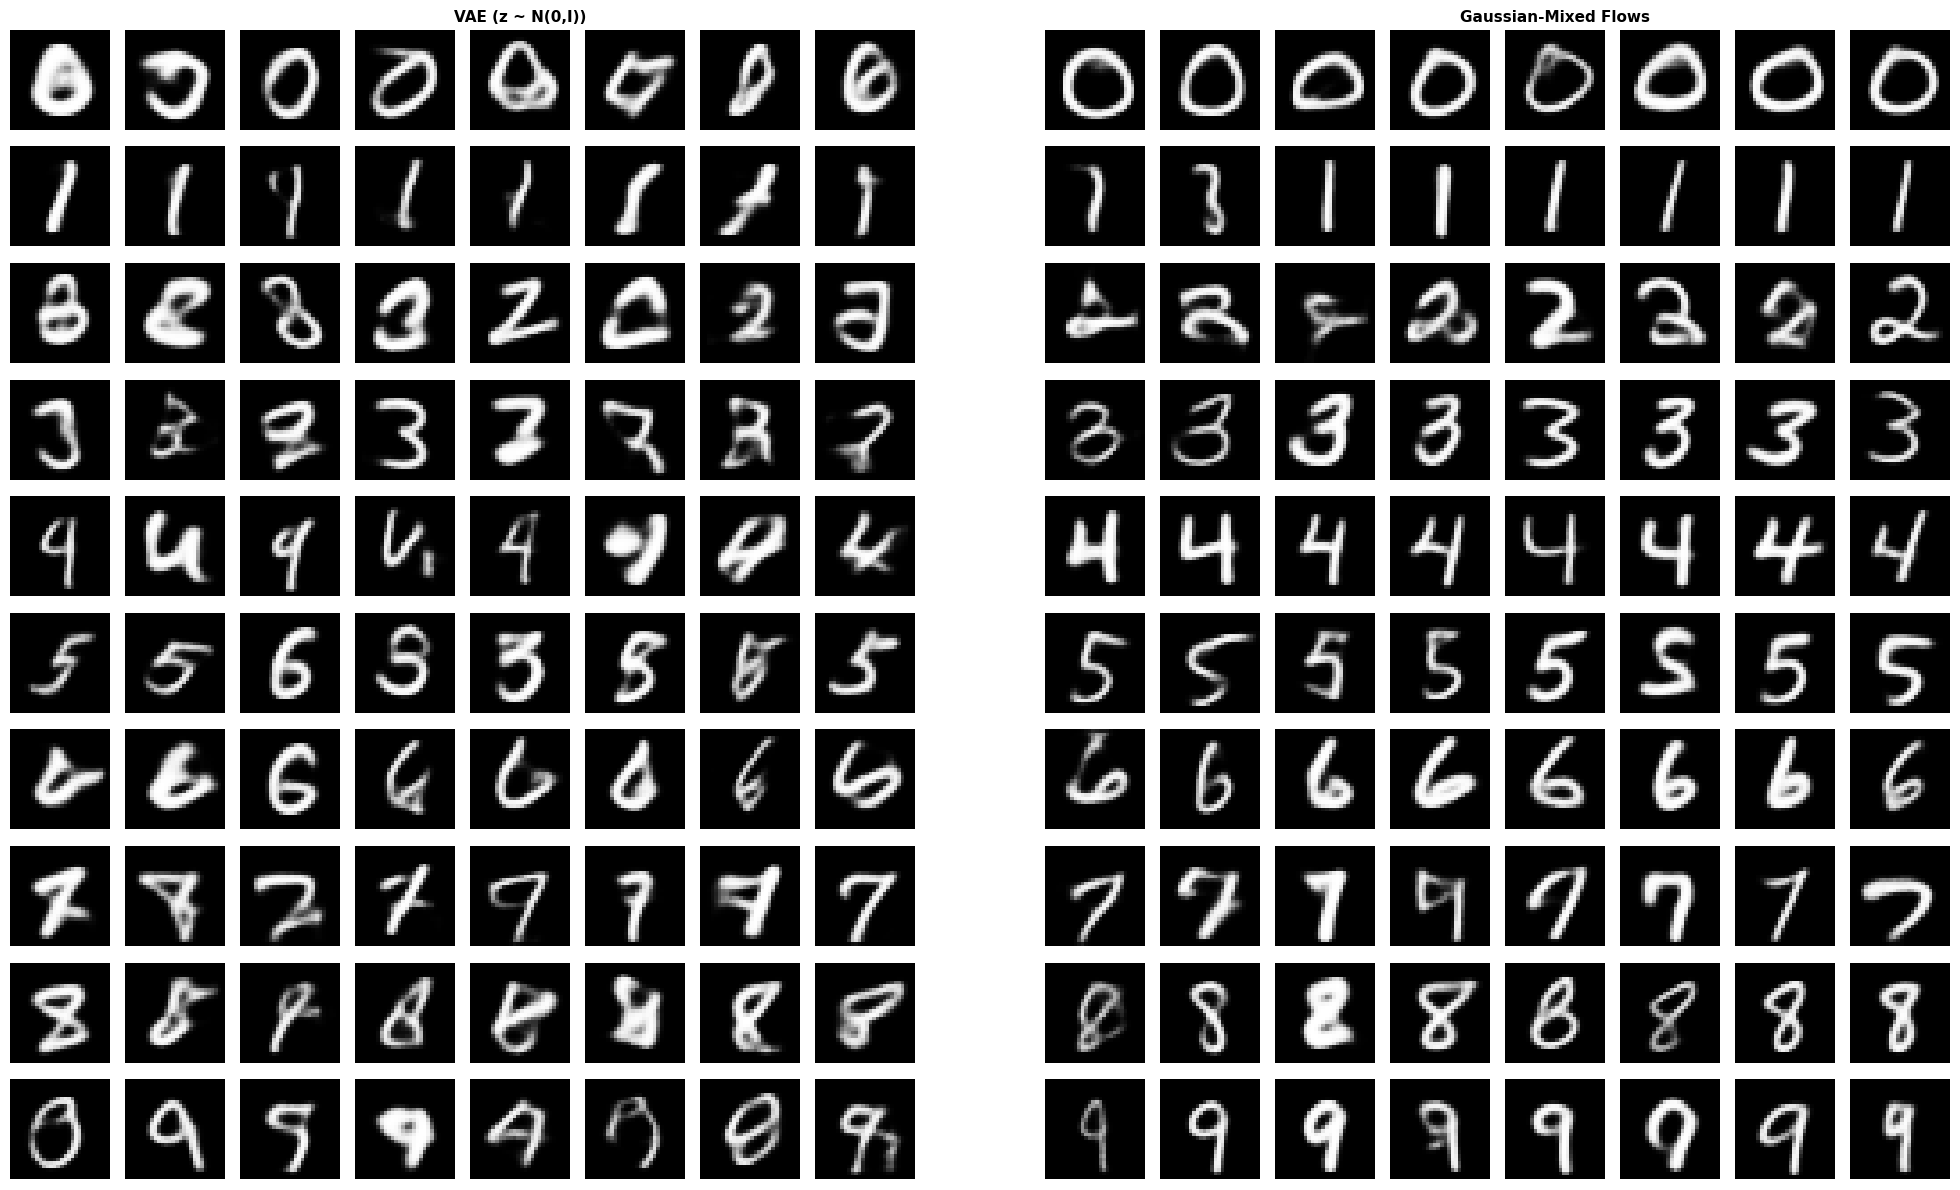

In [ ]:
#Create plot of VAE generated images vs. our model generated images

nGenerate = 512

vae.eval(); model.eval(); classifier.eval()
with torch.no_grad():
    zPrior = torch.randn(nGenerate, latentDim, device=device)
    vaeImgs = torch.sigmoid(vae.decode(zPrior))
    vaePreds = classifier(vaeImgs).argmax(dim=1).cpu().numpy()

    gmImgs = model.sample(nGenerate, device)
    gmPreds = classifier(gmImgs.to(device)).argmax(dim=1).cpu().numpy()

samplesPerDigit = 8
fig, axes = plt.subplots(10, samplesPerDigit * 2 + 1, figsize=(samplesPerDigit * 2.4 + 0.5, 12))

for digit in range(10):
    vaeIdx = np.where(vaePreds == digit)[0]
    gmIdx  = np.where(gmPreds == digit)[0]

    for j in range(samplesPerDigit):
        axV = axes[digit, j]
        if j < len(vaeIdx):
            axV.imshow(vaeImgs[vaeIdx[j]].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
        axV.axis('off')

        axD = axes[digit, samplesPerDigit + 1 + j]
        if j < len(gmIdx):
            axD.imshow(gmImgs[gmIdx[j]].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
        axD.axis('off')

    axes[digit, samplesPerDigit].axis('off')

    axes[digit, 0].set_ylabel(str(digit), fontsize=12, fontweight='bold',
                                rotation=0, ha='right', va='center')

midV = samplesPerDigit // 2
midD = samplesPerDigit + 1 + samplesPerDigit // 2
axes[0, midV].set_title("VAE (z ~ N(0,I))", fontsize=11, fontweight='bold')
axes[0, midD].set_title("Gaussian-Mixed Flows", fontsize=11, fontweight='bold')

plt.tight_layout(); plt.show()

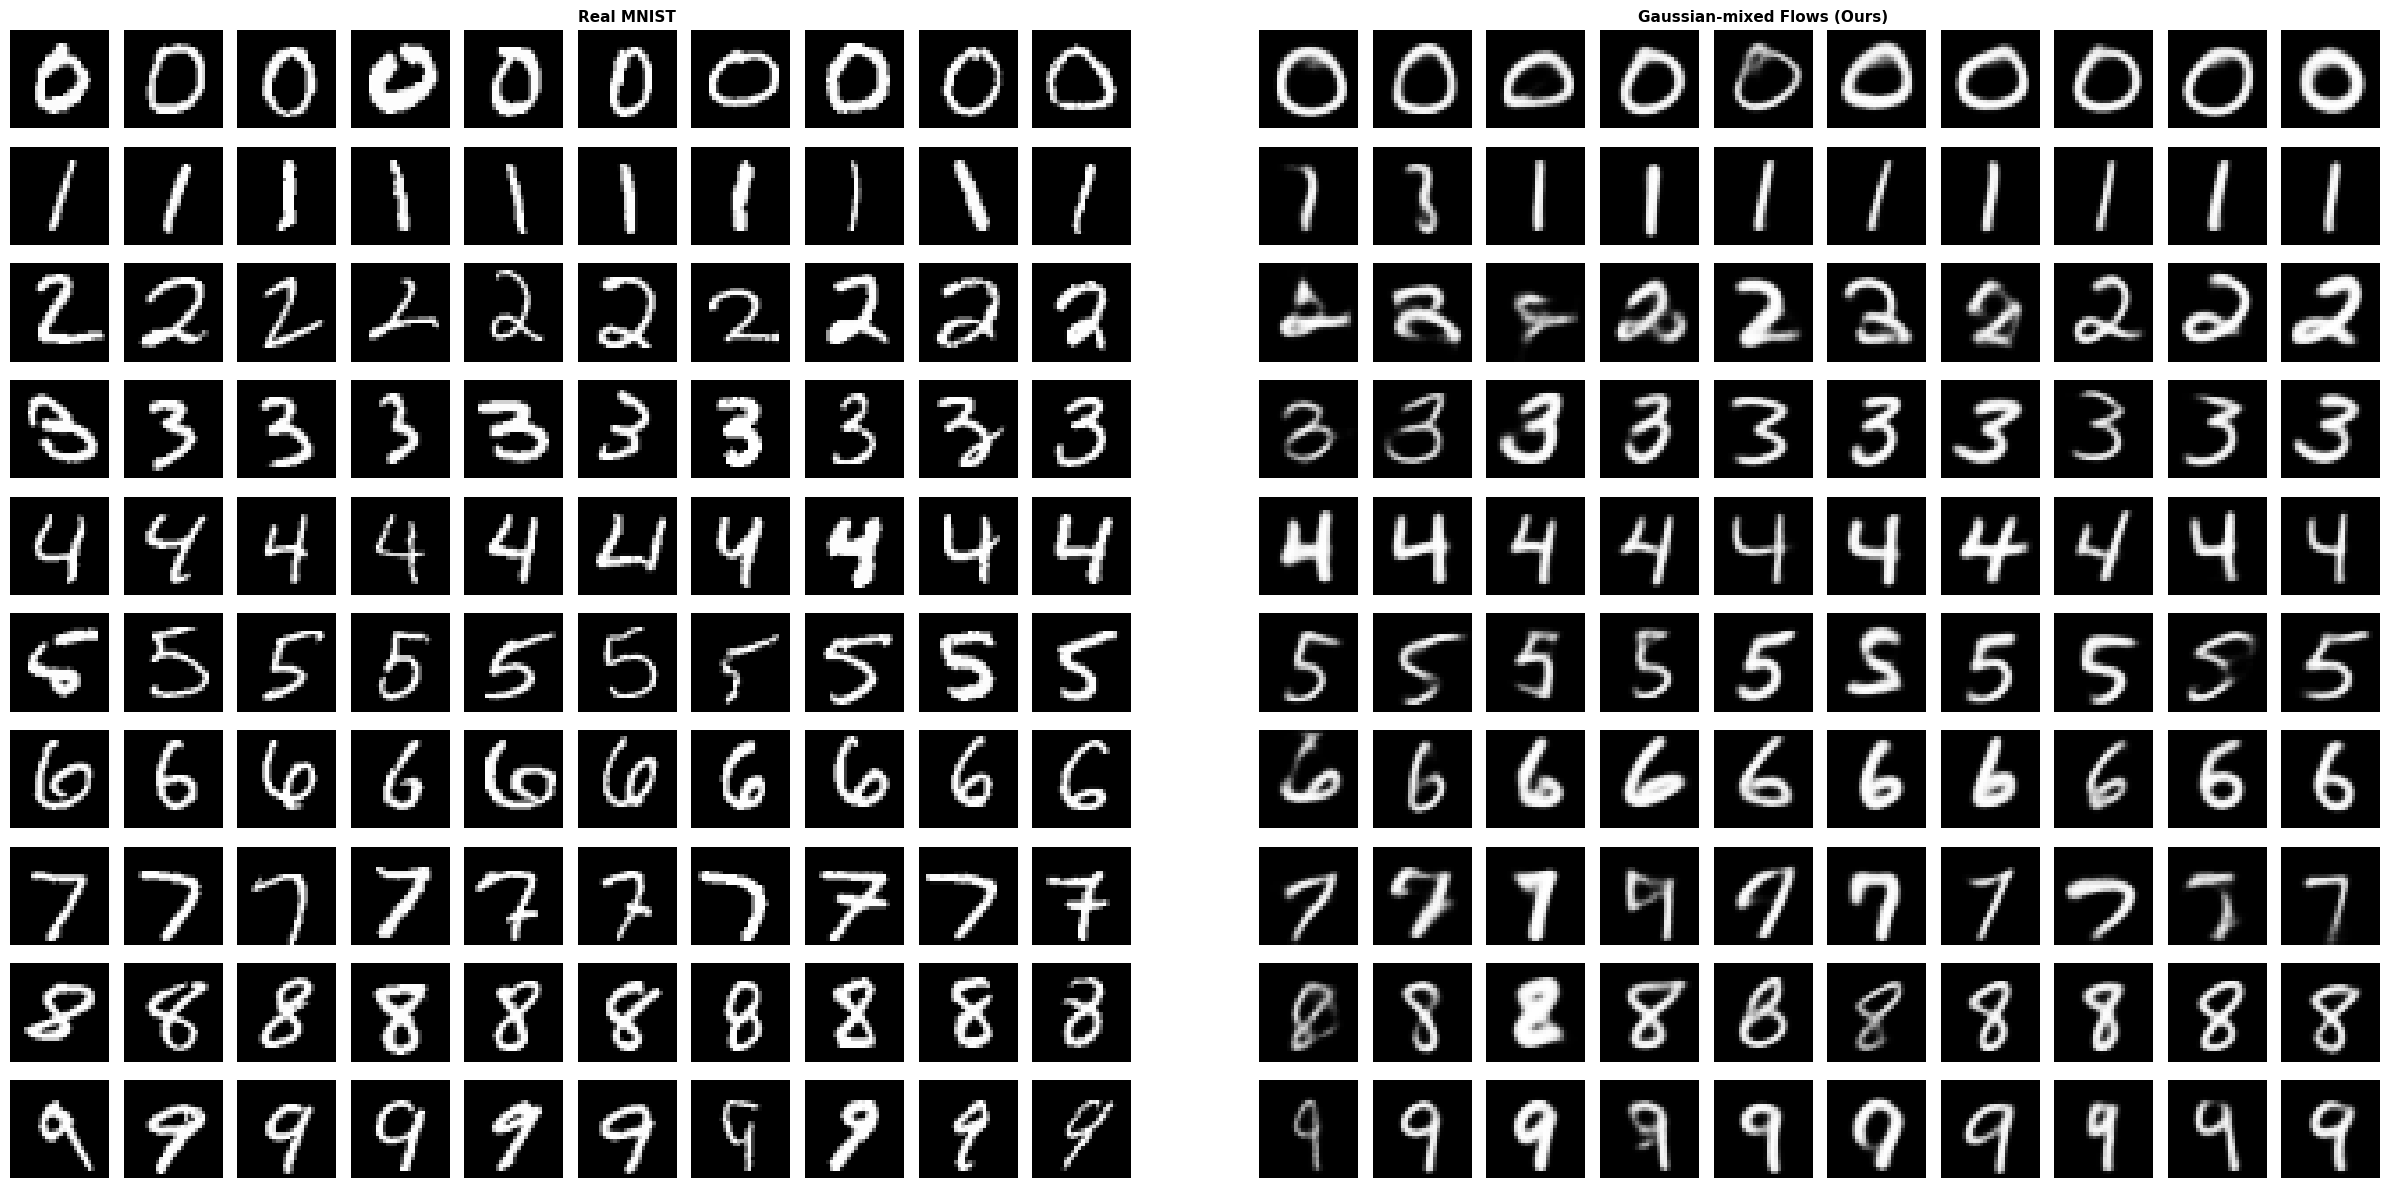

In [ ]:
#Create plot of MNIST real images vs. our model generated images

samplesPerDigit = 10

#gather real examples
realByDigit = {d: [] for d in range(10)}
for x, y in testLoader:
    for i in range(x.size(0)):
        lbl = y[i].item()
        if len(realByDigit[lbl]) < samplesPerDigit:
            realByDigit[lbl].append(x[i])
    if all(len(v) >= samplesPerDigit for v in realByDigit.values()):
        break

fig, axes = plt.subplots(10, samplesPerDigit * 2 + 1, figsize=(samplesPerDigit * 2.4, 12))

with torch.no_grad():
    gmLarge = model.sample(512, device)
    gmPreds2 = classifier(gmImgs.to(device)).argmax(dim=1).cpu().numpy()

for digit in range(10):
    gmIdx = np.where(gmPreds2 == digit)[0]
    for j in range(samplesPerDigit):
        #real
        axes[digit, j].imshow(realByDigit[digit][j].squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[digit, j].axis('off')
        #generated
        axG = axes[digit, samplesPerDigit + 1 + j]

        if j < len(gmIdx):
            axG.imshow(gmLarge[gmIdx[j]].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
        axG.axis('off')

    axes[digit, samplesPerDigit].axis('off')
    axes[digit, 0].set_ylabel(str(digit), fontsize=12, fontweight='bold',
                                rotation=0, ha='right', va='center')

midR = samplesPerDigit // 2
midG = samplesPerDigit + samplesPerDigit // 2
axes[0, midR].set_title("Real MNIST", fontsize=11, fontweight='bold')
axes[0, midG].set_title("Gaussian-mixed Flows (Ours)", fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

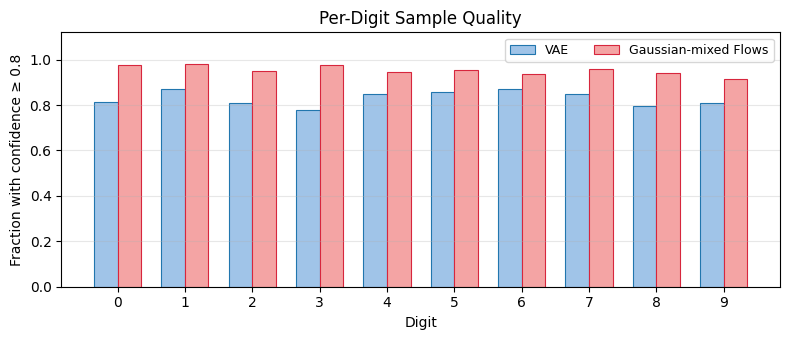

In [ ]:
#Create plot for quality of VAE vs. our model for each digit

confThreshold = 0.8
nForAvg = 2048

vae.eval(); model.eval(); classifier.eval()
with torch.no_grad():
    zPriorAvg = torch.randn(nForAvg, latentDim, device=device)
    vaeImgsAvg = torch.sigmoid(vae.decode(zPriorAvg))
    vaePredsAvg = classifier(vaeImgsAvg).argmax(dim=1).cpu().numpy()
    vaeConf = F.softmax(classifier(vaeImgsAvg), dim=1).max(dim=1).values.cpu().numpy()

    gmImgsAvg = model.sample(nForAvg, device)
    gmPredsAvg = classifier(gmImgsAvg.to(device)).argmax(dim=1).cpu().numpy()
    gmConf = F.softmax(classifier(gmImgsAvg.to(device)), dim=1).max(dim=1).values.cpu().numpy()

vaeAccPerDigit = []
gmAccPerDigit  = []
for digit in range(10):
    vaeIdx = np.where(vaePredsAvg == digit)[0]
    gmIdx  = np.where(gmPredsAvg == digit)[0]
    vaeAccPerDigit.append(np.mean(vaeConf[vaeIdx] >= confThreshold) if len(vaeIdx) > 0 else 0.0)
    gmAccPerDigit.append(np.mean(gmConf[gmIdx]   >= confThreshold) if len(gmIdx) > 0 else 0.0)

xDigits = np.arange(10)
width = 0.35
fig, ax = plt.subplots(figsize=(8, 3.5))
ax.bar(xDigits - width/2, vaeAccPerDigit, width, label='VAE', color='#A0C4E8', edgecolor='#2176AE', linewidth=0.8)
ax.bar(xDigits + width/2, gmAccPerDigit,  width, label='Gaussian-mixed Flows', color='#F4A4A4', edgecolor='#D7263D', linewidth=0.8)
ax.set_xlabel("Digit"); ax.set_ylabel(f"Fraction with confidence ≥ {confThreshold}")
ax.set_title("Per-Digit Sample Quality")
ax.set_xticks(xDigits)
ax.set_ylim(0, 1.12)
ax.legend(ncol=2,frameon=True,fontsize=9)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [ ]:
#Create samples for calculating quantitative values

nEvalSamples = 10000
print(f"Generating {nEvalSamples} samples from each model for evaluation...")

vae.eval(); model.eval(); classifier.eval()
with torch.no_grad():
    #VAE samples
    zEval = torch.randn(nEvalSamples, latentDim, device=device)
    vaeEvalImgs = torch.sigmoid(vae.decode(zEval))
    vaeEvalLogits = classifier(vaeEvalImgs)
    vaeEvalSoftmax = F.softmax(vaeEvalLogits, dim=1)
    vaeEvalPreds = vaeEvalLogits.argmax(dim=1).cpu().numpy()
    vaeEvalConf  = vaeEvalSoftmax.max(dim=1).values.cpu().numpy()
    vaeEvalProbs = vaeEvalSoftmax.cpu().numpy()

    #Gaussian-mixed Flows samples
    gmEvalImgs = model.sample(nEvalSamples, device)
    gmEvalLogits = classifier(gmEvalImgs.to(device))
    gmEvalSoftmax = F.softmax(gmEvalLogits, dim=1)
    gmEvalPreds = gmEvalLogits.argmax(dim=1).cpu().numpy()
    gmEvalConf  = gmEvalSoftmax.max(dim=1).values.cpu().numpy()
    gmEvalProbs =gmEvalSoftmax.cpu().numpy()

    vaeFeats, gmFeats, realFeats = [], [], []
    featExtractor = nn.Sequential(*list(classifier.net.children())[:-1]).to(device)
    featExtractor.eval()

    for i in range(0, nEvalSamples, 256):
        vaeFeats.append(featExtractor(vaeEvalImgs[i:i+256]).cpu().numpy())
        gmFeats.append(featExtractor(gmEvalImgs[i:i+256].to(device)).cpu().numpy())
    vaeFeats = np.concatenate(vaeFeats)
    gmFeats  = np.concatenate(gmFeats)

    for x, y in testLoader:
        realFeats.append(featExtractor(x.to(device)).cpu().numpy())
        if sum(f.shape[0] for f in realFeats) >= nEvalSamples:
            break
    realFeats = np.concatenate(realFeats)[:nEvalSamples]

realDigitDist = np.ones(10) /10.0

Generating 4096 samples from each model for evaluation...



QUANTITATIVE EVALUATION RESULTS
Metric                                               VAE Gaussian-mixed Flows
----------------------------------------------------------------------
Classifier Accuracy (conf ≥ 0.8)                   0.820      0.943
Mean Classifier Confidence                         0.909      0.972
Mode Coverage (unique digits / 10)                    10         10
KL Divergence (vs uniform) ↓                      0.0445     0.0086
Fréchet Distance (classifier feats) ↓             177.33      65.16
Intra-class Pixel Diversity (mean std)            0.1370     0.1346
Mean Component Purity (Gaussian-mixed Flows only)          —      0.853
Mean Component Entropy ↓ (Gaussian-mixed Flows only)          —      0.524

Component      Weight   Dominant   Purity   Entropy
----------------------------------------------------
C0              0.032          4    0.900     0.408
C1              0.035          9    0.969     0.177
C2              0.027          0    0.989     0.072
C

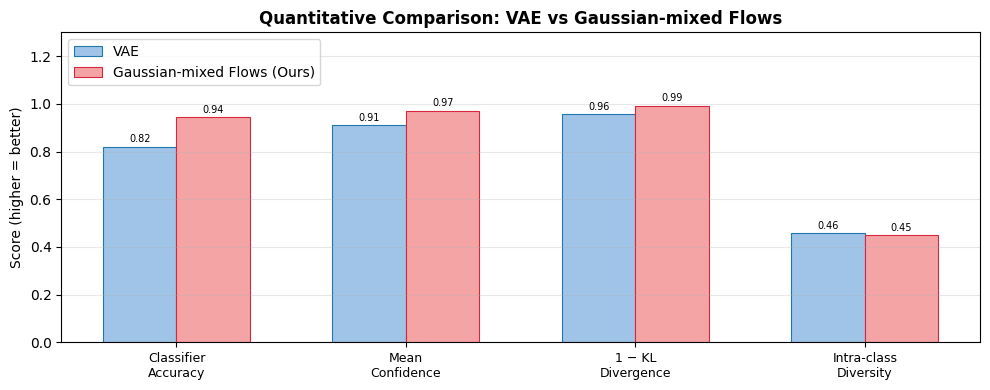

In [ ]:
#performance Metrics here

#Metric 1: Classifier Accuracy (fraction of high-confidence predictions)
confThreshEval = 0.8
vaeAcc = np.mean(vaeEvalConf >= confThreshEval)
gmAcc  = np.mean(gmEvalConf  >= confThreshEval)

#Metric 2: Mode Coverage
vaeCoverage = len(np.unique(vaeEvalPreds))
gmCoverage  = len(np.unique(gmEvalPreds))

#Metric 3: KL divergence (label distribution vs uniform)
def klDivergence(pTrue, pGen):
    pGen = np.clip(pGen, 1e-10, None)
    pTrue = np.clip(pTrue, 1e-10, None)
    return np.sum(pTrue * np.log(pTrue / pGen))

vaeDigitDist = np.bincount(vaeEvalPreds, minlength=10).astype(float)
vaeDigitDist /= vaeDigitDist.sum()
gmDigitDist = np.bincount(gmEvalPreds, minlength=10).astype(float)
gmDigitDist /= gmDigitDist.sum()

vaeKl = klDivergence(realDigitDist, vaeDigitDist)
gmKl  = klDivergence(realDigitDist, gmDigitDist)

#Metric 4:Mean Classifier Confidence
vaeMeanConf = vaeEvalConf.mean()
gmMeanConf  = gmEvalConf.mean()

#Metric 5: Component purity (Gaussian-mixed Flows only)
purityEval = computeComponentPurity(model, classifier)
purityValues = [v['frac'] for v in purityEval.values()]
meanPurity = np.mean(purityValues)

#Metric 6: component Entropy (Gaussian-mixed Flows only)
componentEntropies = []
for k, v in purityEval.items():
    counts = v['counts']
    total = sum(counts.values())
    if total == 0:
        componentEntropies.append(0.0)
        continue
    probs = np.array([counts.get(d, 0) / total for d in range(10)])
    probs = probs[probs > 0]
    componentEntropies.append(-np.sum(probs * np.log(probs)))
meanEntropy = np.mean(componentEntropies)

#Metric 7: Fréchet Distance (classifier feature space)
def frechetDistance(featsA, featsB):
    muA, muB = featsA.mean(0), featsB.mean(0)
    covA = np.cov(featsA, rowvar=False) + np.eye(featsA.shape[1]) * 1e-6
    covB = np.cov(featsB, rowvar=False) + np.eye(featsB.shape[1]) * 1e-6
    diff = muA - muB
    from scipy.linalg import sqrtm
    covMean = sqrtm(covA @ covB)
    if np.iscomplexobj(covMean):
        covMean = covMean.real
    return float(diff @ diff + np.trace(covA + covB - 2 * covMean))

vaeFid = frechetDistance(realFeats, vaeFeats)
gmFid  = frechetDistance(realFeats, gmFeats)

#Metric 8: Intra-class diversity (mean pixel std within each digit)
vaeIntraStd, gmIntraStd = [], []
for digit in range(10):
    vIdx = np.where(vaeEvalPreds == digit)[0]
    dIdx = np.where(gmEvalPreds  == digit)[0]
    if len(vIdx) > 1:
        vaeIntraStd.append(vaeEvalImgs[vIdx].cpu().std(0).mean().item())
    if len(dIdx) > 1:
        gmIntraStd.append(gmEvalImgs[dIdx].cpu().std(0).mean().item())
vaeMeanIntraStd = np.mean(vaeIntraStd) if vaeIntraStd else 0.0
gmMeanIntraStd  = np.mean(gmIntraStd) if gmIntraStd else 0.0


print("\n" + "=" * 70)
print("QUANTITATIVE EVALUATION RESULTS")
print("=" * 70)
print(f"{'Metric':<45} {'VAE':>10} {'Gaussian-mixed Flows':>10}")
print("-" * 70)
print(f"{'Classifier Accuracy (conf ≥ 0.8)':<45} {vaeAcc:>10.3f} {gmAcc:>10.3f}")
print(f"{'Mean Classifier Confidence':<45} {vaeMeanConf:>10.3f} {gmMeanConf:>10.3f}")
print(f"{'Mode Coverage (unique digits / 10)':<45} {vaeCoverage:>10d} {gmCoverage:>10d}")
print(f"{'KL Divergence (vs uniform) ↓':<45} {vaeKl:>10.4f} {gmKl:>10.4f}")
print(f"{'Fréchet Distance (classifier feats) ↓':<45} {vaeFid:>10.2f} {gmFid:>10.2f}")
print(f"{'Intra-class Pixel Diversity (mean std)':<45} {vaeMeanIntraStd:>10.4f} {gmMeanIntraStd:>10.4f}")
print(f"{'Mean Component Purity (Gaussian-mixed Flows only)':<45} {'—':>10} {meanPurity:>10.3f}")
print(f"{'Mean Component Entropy(Gaussian-mixed Flows only)':<45} {'—':>10} {meanEntropy:>10.3f}")
print("=" * 70)

print(f"\n{'Component':<12} {'Weight':>8} {'Dominant':>10} {'Purity':>8} {'Entropy':>9}")
print("-" * 52)
for k in range(nComp):
    w = mixBase.model.weights_[k]
    dom = purityEval[k]['dominant']
    pur = purityEval[k]['frac']
    ent = componentEntropies[k]
    print(f"{'C' + str(k):<12} {w:>8.3f} {str(dom):>10} {pur:>8.3f} {ent:>9.3f}")
print()


metricNames = [
    "Classifier\nAccuracy",
    "Mean\nConfidence",
    "1 − KL\nDivergence",
    "Intra-class\nDiversity"
]
vaeValues = [vaeAcc, vaeMeanConf, 1 - vaeKl, vaeMeanIntraStd / 0.3]
gmValues  = [gmAcc,  gmMeanConf,  1 - gmKl,  gmMeanIntraStd /0.3]

xM = np.arange(len(metricNames))
width = 0.32
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(xM - width/2, vaeValues, width, label='VAE', color='#A0C4E8', edgecolor='#2176AE', linewidth=0.8)
ax.bar(xM + width/2, gmValues,  width, label='Gaussian-mixed Flows (Ours)', color='#F4A4A4', edgecolor='#D7263D', linewidth=0.8)
ax.set_xticks(xM); ax.set_xticklabels(metricNames, fontsize=9)
ax.set_ylabel("Score (higher = better)"); ax.set_ylim(0, 1.3)
ax.set_title("Quantitative Comparison: VAE vs Gaussian-mixed Flows", fontweight='bold')
ax.legend(loc='upper left'); ax.grid(axis='y', alpha=0.3)
#add value labels on bars
for i, (v1, v2) in enumerate(zip(vaeValues, gmValues)):
    ax.text(i - width/2, v1 + 0.02, f"{v1:.2f}", ha='center', fontsize=7)
    ax.text(i + width/2, v2 + 0.02, f"{v2:.2f}", ha='center', fontsize=7)
plt.tight_layout()
plt.show()